In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = False

In [8]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [5]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

## Example image

In [6]:
image = Image.open('/home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion/mmexport1730914510015.png')
image = np.array(image.convert("RGB"))

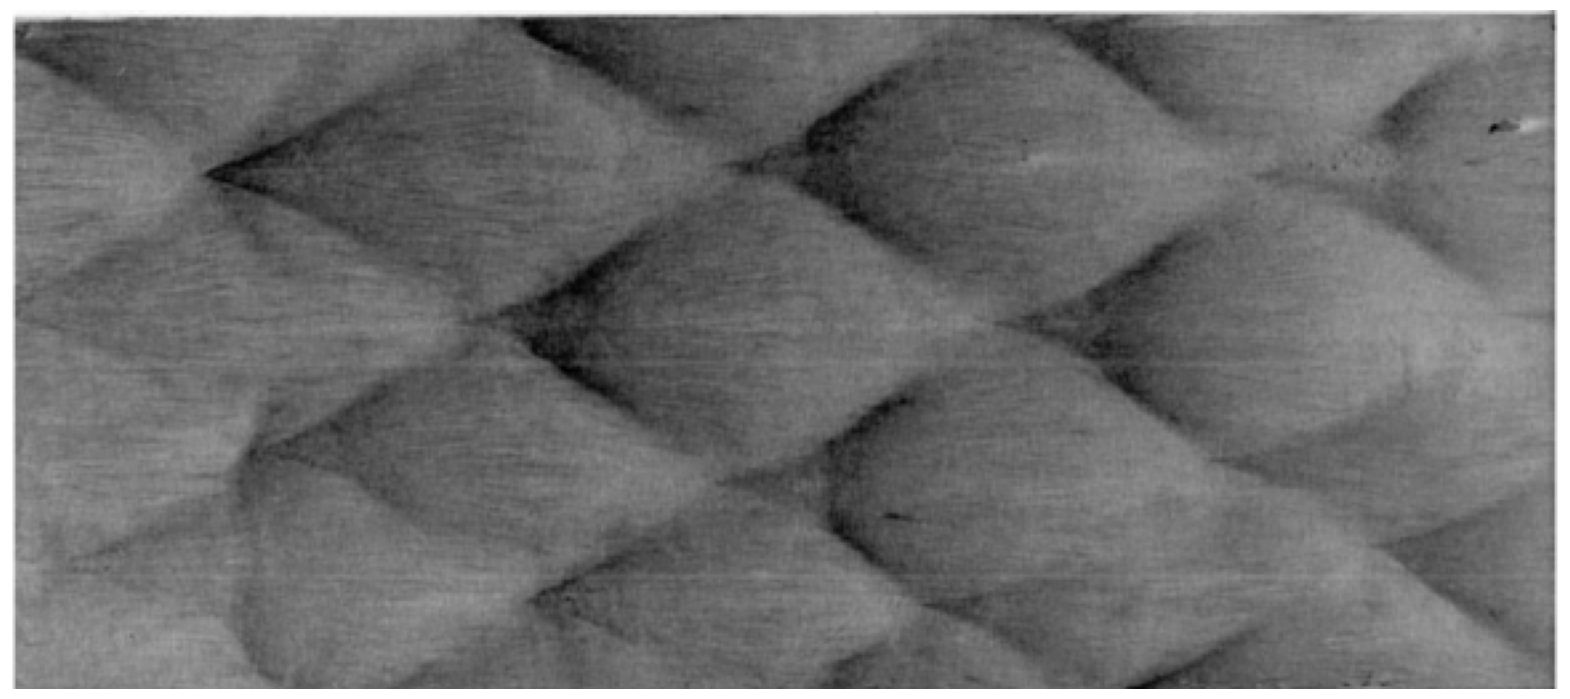

In [7]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [8]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [11]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [12]:
masks2 = mask_generator_2.generate(image)

/home/ubuntu/wkspace2/Research/SAM2/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/ubuntu/wkspace2/Research/SAM2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


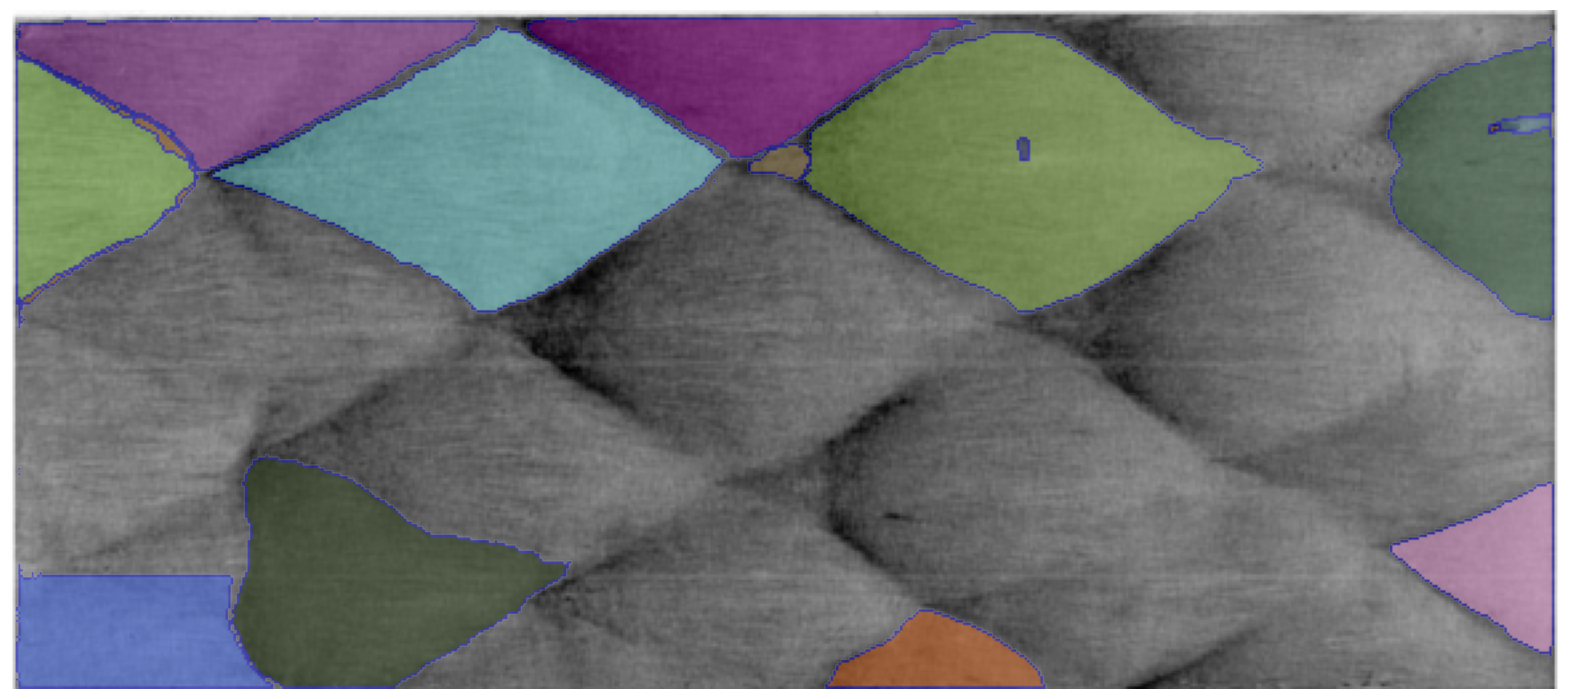

In [13]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

Save all of the masks and the overlay visualization to the output directory.

In [16]:
# Create output directory if it doesn't exist
import os
base_output_dir = "/home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion_outputs"
masks_dir = os.path.join(base_output_dir, "masks")
overlay_dir = os.path.join(base_output_dir, "overlay")
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(overlay_dir, exist_ok=True)

# Save individual masks
for idx, mask_data in enumerate(masks2):
    # Get the binary mask
    mask = mask_data['segmentation'].astype(np.uint8) * 255
    
    # Save as PNG in masks subfolder
    mask_path = os.path.join(masks_dir, f'mask_{idx}.png')
    Image.fromarray(mask).save(mask_path)

# Save overlay visualization in overlay subfolder
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.savefig(os.path.join(overlay_dir, 'masks_overlay.png'), bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Saved {len(masks2)} individual masks to {masks_dir}/")
print(f"Saved overlay visualization to {overlay_dir}/")

Saved 16 individual masks to /home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion_outputs/masks/
Saved overlay visualization to /home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion_outputs/overlay/


Filtering masks by shape and saving them to a new directory.

In [38]:
import cv2
import numpy as np
from PIL import Image
import os

# Create post-processing directory
post_processing_dir = os.path.join(base_output_dir, "post_processing")
os.makedirs(post_processing_dir, exist_ok=True)

def get_shape_type(contour, epsilon_factor=0.02):
    # Approximate the contour
    perimeter = cv2.arcLength(contour, True)
    epsilon = epsilon_factor * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    num_vertices = len(approx)
    
    # For more accurate shape detection, analyze angles and sides
    if num_vertices == 3:
        return "triangle"
    elif num_vertices == 4:
        # Get bounding rect
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w)/h
        
        # Check if it's roughly square-like (diamond)
        if 0.8 <= aspect_ratio <= 1.2:
            return "diamond"
        else:
            return "quadrilateral"
    return "other"

# Process each mask
shape_counts = {"triangle": 0, "diamond": 0, "quadrilateral": 0}

for idx, mask_data in enumerate(masks2):
    # Get the binary mask
    mask = mask_data['segmentation'].astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Process the largest contour
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        shape_type = get_shape_type(main_contour)
        
        if shape_type in ["triangle", "diamond", "quadrilateral"]:
            # Save the mask
            mask_image = mask * 255  # Convert to 0-255 range
            save_path = os.path.join(post_processing_dir, f'mask_{idx}_{shape_type}_{shape_counts[shape_type]}.png')
            Image.fromarray(mask_image).save(save_path)
            
            # Save visualization with contour
            vis_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            cv2.drawContours(vis_image, [main_contour], -1, (255, 255, 255), 2)
            vis_save_path = os.path.join(post_processing_dir, f'mask_{idx}_{shape_type}_{shape_counts[shape_type]}_contour.png')
            Image.fromarray(vis_image).save(vis_save_path)
            
            shape_counts[shape_type] += 1

# Create and save overlay of identified shapes
plt.figure(figsize=(20, 20))
plt.imshow(image)
identified_masks = []
for idx, mask_data in enumerate(masks2):
    mask = mask_data['segmentation']
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        shape_type = get_shape_type(main_contour)
        if shape_type in ["triangle", "diamond", "quadrilateral"]:
            identified_masks.append(mask_data)
show_anns(identified_masks)
plt.axis('off')

# Create overlay subdirectory in post_processing
overlay_dir = os.path.join(post_processing_dir, "overlay")
os.makedirs(overlay_dir, exist_ok=True)
plt.savefig(os.path.join(overlay_dir, 'identified_shapes_overlay.png'), 
            bbox_inches='tight', pad_inches=0)
plt.close()

print("Shape detection results:")
for shape, count in shape_counts.items():
    print(f"- {shape}: {count} masks")
print(f"\nResults saved to: {post_processing_dir}")

Shape detection results:
- triangle: 2 masks
- diamond: 0 masks
- quadrilateral: 4 masks

Results saved to: /home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion_outputs/post_processing


Calcualte the characteristic length of the triangle and diamond shape masks

In [39]:
def calculate_characteristic_length(contour, shape_type):
    # Get contour points
    points = contour.reshape(-1, 2)
    
    # Find min and max coordinates
    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)
    
    # Calculate characteristic lengths
    horizontal_length = x_max - x_min
    vertical_length = y_max - y_min
    
    return {
        "horizontal": horizontal_length,
        "vertical": vertical_length
    }

# Create list to store results for CSV
results_data = []

# Process each mask and calculate lengths
for idx, mask_data in enumerate(masks2):
    mask = mask_data['segmentation'].astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(main_contour)
        shape_type = get_shape_type(main_contour)
        
        if shape_type in ["triangle", "diamond", "quadrilateral"]:
            # Calculate characteristic lengths
            lengths = calculate_characteristic_length(main_contour, shape_type)
            
            # Store results for CSV
            results_data.append({
                'mask_number': idx,
                'shape_type': shape_type,
                'area': area,
                'horizontal_length': lengths['horizontal'],
                'vertical_length': lengths['vertical']
            })
            
            # Save visualization with contour and characteristic lines
            vis_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            
            # Draw original contour
            cv2.drawContours(vis_image, [main_contour], -1, (255, 255, 255), 2)
            
            # Get points for visualization
            points = main_contour.reshape(-1, 2)
            x_min, y_min = points.min(axis=0)
            x_max, y_max = points.max(axis=0)
            
            # Draw characteristic lines
            # Vertical line (blue)
            mid_x = int((x_min + x_max) / 2)
            cv2.line(vis_image, (mid_x, int(y_min)), (mid_x, int(y_max)), (255, 0, 0), 2)
            
            # Horizontal line (red)
            mid_y = int((y_min + y_max) / 2)
            cv2.line(vis_image, (int(x_min), mid_y), (int(x_max), mid_y), (0, 0, 255), 2)
            
            vis_save_path = os.path.join(post_processing_dir, f'mask_{idx}_{shape_type}_characteristic_lines.png')
            Image.fromarray(vis_image).save(vis_save_path)

# Create overlay with characteristic lines
plt.figure(figsize=(20, 20))
plt.imshow(image)

# First draw the masks using show_anns
show_anns(identified_masks)

# Then overlay the characteristic lines for each identified mask
for mask_data in identified_masks:
    mask = mask_data['segmentation'].astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        points = main_contour.reshape(-1, 2)
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)
        
        # Draw characteristic lines
        mid_x = (x_min + x_max) / 2
        mid_y = (y_min + y_max) / 2
        
        # Vertical line (blue)
        plt.plot([mid_x, mid_x], [y_min, y_max], 'b-', linewidth=2)
        # Horizontal line (red)
        plt.plot([x_min, x_max], [mid_y, mid_y], 'r-', linewidth=2)

plt.axis('off')

# Save the overlay with characteristic lines
overlay_dir = os.path.join(post_processing_dir, "overlay")
os.makedirs(overlay_dir, exist_ok=True)
plt.savefig(os.path.join(overlay_dir, 'identified_shapes_with_characteristic_lines.png'), 
            bbox_inches='tight', pad_inches=0)
plt.close()

# Save results to CSV
import pandas as pd
results_df = pd.DataFrame(results_data)
csv_path = os.path.join(post_processing_dir, 'characteristic_lengths.csv')
results_df.to_csv(csv_path, index=False)

print("\nShape detection results:")
for shape, count in shape_counts.items():
    print(f"- {shape}: {count} masks")
print(f"\nResults saved to: {post_processing_dir}")
print(f"Characteristic lengths saved to: {csv_path}")

# Print detailed measurements for debugging
print("\nDetailed measurements:")
for result in results_data:
    print(f"Mask {result['mask_number']} ({result['shape_type']}):")
    print(f"  - Area: {result['area']:.2f}")
    print(f"  - Horizontal length: {result['horizontal_length']:.2f}")
    print(f"  - Vertical length: {result['vertical_length']:.2f}")


Shape detection results:
- triangle: 2 masks
- diamond: 0 masks
- quadrilateral: 4 masks

Results saved to: /home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion_outputs/post_processing
Characteristic lengths saved to: /home/ubuntu/wkspace2/Research/SAM2_MultiMasks/Datasets/combustion_outputs/post_processing/characteristic_lengths.csv

Detailed measurements:
Mask 5 (triangle):
  - Area: 2129.00
  - Horizontal length: 61.00
  - Vertical length: 65.00
Mask 8 (quadrilateral):
  - Area: 10449.50
  - Horizontal length: 193.00
  - Vertical length: 107.00
Mask 9 (quadrilateral):
  - Area: 5372.50
  - Horizontal length: 172.00
  - Vertical length: 57.00
Mask 10 (quadrilateral):
  - Area: 5341.50
  - Horizontal length: 173.00
  - Vertical length: 57.00
Mask 12 (triangle):
  - Area: 4642.50
  - Horizontal length: 168.00
  - Vertical length: 53.00
Mask 15 (quadrilateral):
  - Area: 3795.50
  - Horizontal length: 68.00
  - Vertical length: 103.00


Add area to the shape detection. But it is not working well and still need to be improved.

In [28]:
import cv2
import numpy as np
from PIL import Image
import os

# Create post-processing directory
post_processing_dir = os.path.join(base_output_dir, "post_processing")
os.makedirs(post_processing_dir, exist_ok=True)

def get_shape_type(contour, area, epsilon_factor=0.04):
    # Filter by area first
    min_area = 120  # Adjust this threshold based on your image size
    max_area = 50000  # Adjust this threshold based on your image size
    
    if area < min_area or area > max_area:
        return "other"
    
    # Rest of shape detection logic
    perimeter = cv2.arcLength(contour, True)
    epsilon = epsilon_factor * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    num_vertices = len(approx)
    
    # Get shape metrics
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area if hull_area > 0 else 0
    
    # Get bounding rect
    x, y, w, h = cv2.boundingRect(approx)
    aspect_ratio = float(w)/h
    
    # Enhanced shape detection logic
    if 3 <= num_vertices <= 4:
        # For triangular shapes
        if (num_vertices == 3) or (num_vertices == 4 and solidity > 0.85):
            if solidity > 0.85:
                return "triangle"
                
        # For diamond shapes
        if num_vertices == 4:
            if 0.7 <= aspect_ratio <= 1.3 and solidity > 0.85:
                return "diamond"
            else:
                return "quadrilateral"
                
    # Additional check for triangular shapes
    if 4 < num_vertices <= 6 and solidity > 0.85:
        if aspect_ratio > 0.6 and aspect_ratio < 1.4:
            return "triangle"
    
    return "other"

# Process masks
shape_counts = {"triangle": 0, "diamond": 0, "quadrilateral": 0}
identified_masks = []

print("\nAnalyzing masks:")
for idx, mask_data in enumerate(masks2):
    # Get the binary mask
    mask = mask_data['segmentation'].astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(main_contour)
        
        # Print area for debugging
        print(f"Mask {idx}: Area = {area:.2f}")
        
        shape_type = get_shape_type(main_contour, area)
        
        if shape_type in ["triangle", "diamond", "quadrilateral"]:
            # Save the mask with new naming convention
            mask_image = mask * 255
            save_path = os.path.join(post_processing_dir, f'mask_{idx}_{shape_type}_{shape_counts[shape_type]}.png')
            Image.fromarray(mask_image).save(save_path)
            
            # Save visualization with contour with new naming convention
            vis_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            cv2.drawContours(vis_image, [main_contour], -1, (255, 255, 255), 2)
            vis_save_path = os.path.join(post_processing_dir, f'mask_{idx}_{shape_type}_{shape_counts[shape_type]}_contour.png')
            Image.fromarray(vis_image).save(vis_save_path)
            
            print(f"Mask {idx}: Identified as {shape_type} (Area: {area:.2f})")
            
            shape_counts[shape_type] += 1
            identified_masks.append(mask_data)

# Create and save overlay of identified shapes
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(identified_masks)
plt.axis('off')

# Create overlay subdirectory in post_processing
overlay_dir = os.path.join(post_processing_dir, "overlay")
os.makedirs(overlay_dir, exist_ok=True)

# Save the overlay image
plt.savefig(os.path.join(overlay_dir, 'identified_shapes_overlay.png'), 
            bbox_inches='tight', pad_inches=0)
plt.close()

print("\nShape detection results:")
for shape, count in shape_counts.items():
    print(f"- {shape}: {count} masks")
print(f"\nResults saved to: {post_processing_dir}")


Analyzing masks:
Mask 0: Area = 101.00
Mask 1: Area = 204.00
Mask 2: Area = 27.50
Mask 3: Area = 8.50
Mask 4: Area = 1476.00
Mask 4: Identified as triangle (Area: 1476.00)
Mask 5: Area = 2129.00
Mask 5: Identified as triangle (Area: 2129.00)
Mask 6: Area = 3554.00
Mask 6: Identified as triangle (Area: 3554.00)
Mask 7: Area = 3488.00
Mask 7: Identified as triangle (Area: 3488.00)
Mask 8: Area = 10449.50
Mask 8: Identified as triangle (Area: 10449.50)
Mask 9: Area = 5372.50
Mask 9: Identified as triangle (Area: 5372.50)
Mask 10: Area = 5341.50
Mask 10: Identified as triangle (Area: 5341.50)
Mask 11: Area = 10813.50
Mask 11: Identified as triangle (Area: 10813.50)
Mask 12: Area = 4642.50
Mask 12: Identified as triangle (Area: 4642.50)
Mask 13: Area = 4667.00
Mask 14: Area = 6637.50
Mask 15: Area = 3795.50
Mask 15: Identified as triangle (Area: 3795.50)

Shape detection results:
- triangle: 10 masks
- diamond: 0 masks
- quadrilateral: 0 masks

Results saved to: /home/ubuntu/wkspace2/Resea